In [1]:
import numpy as np
import matplotlib.pyplot as plt

This is all $O_2$. How do I include the absorption of a single oxygen atom? Answered in Yata, I think...

In [2]:
from ase.build import molecule
from gpaw import GPAW, PW
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

In [3]:
def Entropy(T):
  # Definitions:
  a = 12
  h = 0.2
  ecut = 450
  S_O2 = []; S_CO = []
  for name in ['O2', 'CO']:
    for Temp in T:
      sigma = 1 # Symmetry number - default = 1
      molecule_Obj = molecule(f'{name}')
      molecule_Obj.set_cell((a, a, a))
      molecule_Obj.center()
      calc = GPAW(h = h, mode = PW(ecut), xc = 'PBE', txt = f'T5_{name}.txt', symmetry = {'point_group': False})
      if(name == 'O2'): calc.set(hund=True); sigma = 2 # Spin-polarized calculations!
      molecule_Obj.calc = calc

      # Set up vibration calculations using previously optimized molecule
      vib = Vibrations(molecule_Obj, name = f'vibs/{name}_vib_{Temp}K')
      vib.run()
      # print(vib.summary())
      vib_energies = vib.get_energies()

      # Save vibration modes to review if imaginary frequency present. What do these mean?
      # for mode in range(3*len(molecule_Obj.numbers)): # I'm removing these, for now. This should yield faster calculations, I hope...
      #   vib.write_mode(mode)

      potentialenergy = molecule_Obj.get_potential_energy()

      # Perform ideal gas calculations assuming ideal gas
      thermo = IdealGasThermo(vib_energies = vib_energies,
                            potentialenergy = potentialenergy,
                            atoms=molecule_Obj,
                            geometry='linear',       # adjust this
                            symmetrynumber=sigma,    # adjust this
                            spin=1                   # adjust this
                            )
      G = thermo.get_entropy(temperature=Temp, pressure=101_325)
      if(name == 'O2'): S_O2.append(G)
      else:             S_CO.append(G)
      print(f'[{Temp}][{name}]: Entropy = {G}.')
  return([S_O2, S_CO]) # [Order] O2 and C0.

In [4]:
# Constants
T = np.linspace(100, 2_000, 100)
p_CO = 100_000 # This should be 1 atm? Which is different from 1 bar!
p_O2 = 100_000
S_O2 = 0.0021480
S_CO = 0.0021329
kB = 1.380649e-23 / 1.60217663e-19 # Bolztmann constant in eV/K.
# E_O2 = -0.849 # Testing value from the ASE tutorial.
E_O2 = -8.729
E_CO = -14.194

# # Testing values from the ASE tutorial:
# E_ads_O2_Au = -4.699
# E_ads_CO_Au =  1.946
# E_ads_O2_Pt = -6.062
# E_ads_CO_Pt =  0.634
# E_ads_O2_Rh = -6.773
# E_ads_CO_Rh =  0.942
# E_a_Au = -0.3*(E_ads_O2_Au + E_ads_CO_Au) + 0.22
# E_a_Pt = -0.3*(E_ads_O2_Pt + E_ads_CO_Pt) + 0.22 
# E_a_Rh = -0.3*(E_ads_O2_Rh + E_ads_CO_Rh) + 0.22

E_ads_O2_Au = 0.3155
E_ads_CO_Au = -0.047
E_ads_O2_Pt = -1.0625
E_ads_CO_Pt = -1.753
E_ads_O2_Rh = -1.3285
E_ads_CO_Rh = -1.258
nu = 1e12
E_a_Au = 0.13945
E_a_Pt = 1.06465
E_a_Rh = 0.99595

# Definitions
K_O2_Au = np.exp(-Entropy(T)[0]/kB) * np.exp((E_O2 - E_ads_O2_Au)/(kB*T))
K_CO_Au = np.exp(-Entropy(T)[1]/kB) * np.exp((E_CO - E_ads_CO_Au)/(kB*T))
K_O2_Pt = np.exp(-Entropy(T)[0]/kB) * np.exp((E_O2 - E_ads_O2_Pt)/(kB*T))
K_CO_Pt = np.exp(-Entropy(T)[1]/kB) * np.exp((E_CO - E_ads_CO_Pt)/(kB*T))
K_O2_Rh = np.exp(-Entropy(T)[0]/kB) * np.exp((E_O2 - E_ads_O2_Rh)/(kB*T))
K_CO_Rh = np.exp(-Entropy(T)[1]/kB) * np.exp((E_CO - E_ads_CO_Rh)/(kB*T))

theta_O2_Au = np.sqrt(K_O2_Au * p_O2)/(1 + np.sqrt(K_O2_Au * p_O2) + K_CO_Au * p_CO)
theta_CO_Au = K_CO_Au * p_CO/(1 + np.sqrt(K_O2_Au * p_O2) + K_CO_Au * p_CO)
theta_O2_Pt = np.sqrt(K_O2_Pt * p_O2)/(1 + np.sqrt(K_O2_Pt * p_O2) + K_CO_Pt * p_CO)
theta_CO_Pt = K_CO_Pt * p_CO/(1 + np.sqrt(K_O2_Pt * p_O2) + K_CO_Pt * p_CO)
theta_O2_Rh = np.sqrt(K_O2_Rh * p_O2)/(1 + np.sqrt(K_O2_Rh * p_O2) + K_CO_Rh * p_CO)
theta_CO_Rh = K_CO_Rh * p_CO/(1 + np.sqrt(K_O2_Rh * p_O2) + K_CO_Rh * p_CO)

f_theta_Au = theta_O2_Au * theta_CO_Au
f_theta_Pt = theta_O2_Pt * theta_CO_Pt
f_theta_Rh = theta_O2_Rh * theta_CO_Rh

r_Au = f_theta_Au * nu * np.exp(E_a_Au/(kB * T))
r_Pt = f_theta_Pt * nu * np.exp(E_a_Pt/(kB * T))
r_Rh = f_theta_Rh * nu * np.exp(E_a_Rh/(kB * T))

Entropy components at T = 100.00 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0013408 eV/K        0.134 eV
S_rot              0.0003656 eV/K        0.037 eV
S_elec             0.0000947 eV/K        0.009 eV
S_vib              0.0000000 eV/K        0.000 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0018000 eV/K        0.180 eV
[100.0][O2]: Entropy = 0.0017999696692582601.
Entropy components at T = 119.19 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0013787 eV/K        0.164 eV
S_rot              0.0003807 eV/K        0.045 eV
S_elec             0.0000947 eV/K        0.011 eV
S_vib              0.0000000 eV/K        0.000 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.000 eV
-------------------------------------------------
S                  0.0018529 eV/K        0.221 eV
[119.1919191919192][O2]: Entropy = 0.00185292117

TypeError: 'NoneType' object is not subscriptable

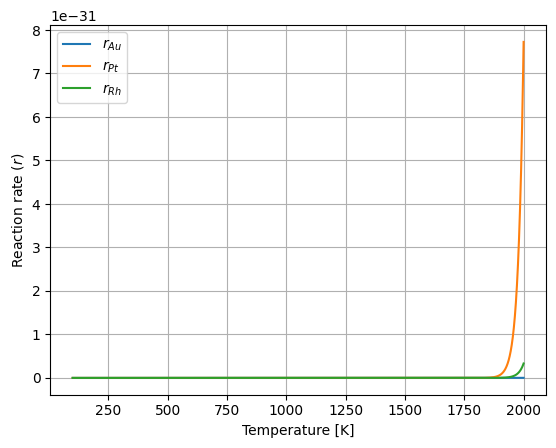

In [ ]:
plt.plot(T, r_Au, label = r'$r_{Au}$')
plt.plot(T, r_Pt, label = r'$r_{Pt}$')
plt.plot(T, r_Rh, label = r'$r_{Rh}$')
plt.xlabel(r'Temperature [K]')
plt.ylabel(r'Reaction rate ($r$)')
plt.grid(True)
plt.legend()
plt.savefig('Reaction_rate(T).png', dpi = 350)
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ase.build import molecule
from gpaw import GPAW, PW
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo

def Entropy(T):
  # Definitions:
  a = 12
  h = 0.2
  ecut = 450
  S_O2 = []; S_CO = []
  for name in ['O2', 'CO']:
    sigma = 1 # Symmetry number - default = 1
    molecule_Obj = molecule(f'{name}')
    molecule_Obj.set_cell((a, a, a))
    molecule_Obj.center()
    calc = GPAW(h = h, mode = PW(ecut), xc = 'PBE', txt = f'T7_{name}.txt', symmetry = {'point_group': False})
    if(name == 'O2'): sigma = 2; calc.set(hund=True)  # Spin-polarized calculations!
    molecule_Obj.calc = calc

    # Set up vibration calculations using previously optimized molecule
    vib = Vibrations(molecule_Obj, name = f'vibs/{name}_vib')
    vib.run()
    # print(vib.summary())
    vib_energies = vib.get_energies()

    # Save vibration modes to review if imaginary frequency present. What do these mean?
    # for mode in range(3*len(molecule_Obj.numbers)): # I'm removing these, for now. This should yield faster calculations, I hope...
    #   vib.write_mode(mode)

    # potentialenergy = molecule_Obj.get_potential_energy()

    # Perform ideal gas calculations assuming ideal gas
    thermo = IdealGasThermo(vib_energies = vib_energies,
                            potentialenergy = 0,
                            atoms=molecule_Obj,
                            geometry='linear',       # adjust this. Both CO and O2 exhibit linear geometry.
                            symmetrynumber=sigma,    # adjust this
                            spin=1                   # adjust this
                            )
    for Temp in T:
      G = thermo.get_entropy(temperature=Temp, pressure=101_325)
      if(name == 'O2'): S_O2.append(G)
      else:             S_CO.append(G)
      print(f'[{Temp}][{name}]: Entropy = {G}.')
  return([np.array(S_O2), np.array(S_CO)]) # [Order] O2 and C0.

# Constants
T = np.linspace(100, 2_000, 1_000) # For some reason, I get a weird peak at T=100?, for Rhodium? Idk why... Will try with this T, now.
p_CO = 101_325                     # Yeah, so this didn't really solve much... Back to 1000 points, in [100, 2000]
p_O2 = 101_325
kB = 1.380649e-23 / 1.60217663e-19 # Bolztmann constant in eV/K.
E_O2 = -8.729
E_CO = -14.194

# Values computed in the tasks before.
nu = 1e12
E_ads_O2_Au = 0.3155*2  # 2 Oxygen atoms are adsorbed!
E_ads_CO_Au = -0.047
E_ads_O2_Pt = -1.0625*2 # 2 Oxygen atoms are adsorbed!
E_ads_CO_Pt = -1.753
E_ads_O2_Rh = -1.3285*2 # 2 Oxygen atoms are adsorbed!
E_ads_CO_Rh = -1.258
E_a_Au = 0.13945
E_a_Pt = 1.06465
E_a_Rh = 0.99595

# Definitions
S_O2 = Entropy(T)[0]
S_CO = Entropy(T)[1]

K_O2_Au = np.exp(-1*S_O2/kB) * np.exp((-E_ads_O2_Au)/(kB*T)) # Changed from: np.exp((E_O2 - E_ads_O2_Au)/(kB*T))
K_CO_Au = np.exp(-1*S_CO/kB) * np.exp((-E_ads_CO_Au)/(kB*T)) # Changed from: np.exp((E_CO - E_ads_CO_Au)/(kB*T))
K_O2_Pt = np.exp(-1*S_O2/kB) * np.exp((-E_ads_O2_Pt)/(kB*T)) # Changed from: np.exp((E_O2 - E_ads_O2_Pt)/(kB*T))
K_CO_Pt = np.exp(-1*S_CO/kB) * np.exp((-E_ads_CO_Pt)/(kB*T)) # Changed from: np.exp((E_CO - E_ads_CO_Pt)/(kB*T))
K_O2_Rh = np.exp(-1*S_O2/kB) * np.exp((-E_ads_O2_Rh)/(kB*T)) # Changed from: np.exp((E_O2 - E_ads_O2_Rh)/(kB*T))
K_CO_Rh = np.exp(-1*S_CO/kB) * np.exp((-E_ads_CO_Rh)/(kB*T)) # Changed from: np.exp((E_CO - E_ads_CO_Rh)/(kB*T))

theta_O2_Au = np.sqrt(K_O2_Au * p_O2)/(1 + np.sqrt(K_O2_Au * p_O2) + K_CO_Au * p_CO)
theta_CO_Au = K_CO_Au * p_CO/(1 + np.sqrt(K_O2_Au * p_O2) + K_CO_Au * p_CO)
theta_O2_Pt = np.sqrt(K_O2_Pt * p_O2)/(1 + np.sqrt(K_O2_Pt * p_O2) + K_CO_Pt * p_CO)
theta_CO_Pt = K_CO_Pt * p_CO/(1 + np.sqrt(K_O2_Pt * p_O2) + K_CO_Pt * p_CO)
theta_O2_Rh = np.sqrt(K_O2_Rh * p_O2)/(1 + np.sqrt(K_O2_Rh * p_O2) + K_CO_Rh * p_CO)
theta_CO_Rh = K_CO_Rh * p_CO/(1 + np.sqrt(K_O2_Rh * p_O2) + K_CO_Rh * p_CO)

f_theta_Au = theta_O2_Au * theta_CO_Au
f_theta_Pt = theta_O2_Pt * theta_CO_Pt
f_theta_Rh = theta_O2_Rh * theta_CO_Rh

r_Au = f_theta_Au * nu * np.exp(E_a_Au/(kB * T))
r_Pt = f_theta_Pt * nu * np.exp(E_a_Pt/(kB * T))
r_Rh = f_theta_Rh * nu * np.exp(E_a_Rh/(kB * T))

# Plotting the results:
# plt.plot(T, r_Au, label = r'$r_{Au}$')
# plt.plot(T, r_Pt, label = r'$r_{Pt}$')
# plt.plot(T, r_Rh, label = r'$r_{Rh}$')
plt.plot(T, theta_O2_Pt, label = r'$\theta_{O_2}$')
plt.plot(T, theta_CO_Pt, label = r'$\theta_{CO}$')
# plt.plot(T,K_O2_Au, label = r'$K_{O_2}$')
# plt.plot(T, K_CO_Au, label = r'$K_{CO}$')
# plt.plot(T,S_O2, label = r'$S_{O_2}$')
# plt.plot(T, S_CO, label = r'$S_{CO}$')
plt.xlabel(r'Temperature [K]')
plt.ylabel(r'Reaction rate ($r$)')
plt.grid(True)
plt.legend()
# plt.savefig('Reaction_rate(T).png', dpi = 350)
plt.savefig('S.png', dpi = 350)

# I might ask about how to manually implement the entropy, i.e., without the ase built-in method (Vibrations).

KeyboardInterrupt: 